In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_b25_targets_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(463113, 1576)
(463113, 1)
validation
(87055, 1576)
(87055, 1)
test
(43409, 1576)
(43409, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2304001 (8.79 MB)


Trainable params: 2304001 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:10 - loss: 0.1501 - STD: 1.1160e-04 - MAE: 0.3722

 3/47 [>.............................] - ETA: 15s - loss: 0.0804 - STD: 4.6021e-04 - MAE: 0.2058 

 5/47 [==>...........................] - ETA: 8s - loss: 0.0524 - STD: 3.7755e-04 - MAE: 0.1650 

 7/47 [===>..........................] - ETA: 5s - loss: 0.0449 - STD: 2.9341e-04 - MAE: 0.1557

 9/47 [====>.........................] - ETA: 4s - loss: 0.0415 - STD: 2.3443e-04 - MAE: 0.1521

11/47 [======>.......................] - ETA: 3s - loss: 0.0394 - STD: 1.9304e-04 - MAE: 0.1497

13/47 [=======>......................] - ETA: 3s - loss: 0.0376 - STD: 1.6501e-04 - MAE: 0.1469

15/47 [========>.....................] - ETA: 2s - loss: 0.0359 - STD: 1.4592e-04 - MAE: 0.1436

17/47 [=========>....................] - ETA: 2s - loss: 0.0341 - STD: 1.3273e-04 - MAE: 0.1392

19/47 [===========>..................] - ETA: 1s - loss: 0.0321 - STD: 1.2341e-04 - MAE: 0.1341

21/47 [============>.................] - ETA: 1s - loss: 0.0302 - STD: 1.1645e-04 - MAE: 0.1292

23/47 [=============>................] - ETA: 1s - loss: 0.0286 - STD: 1.1062e-04 - MAE: 0.1256

25/47 [==============>...............] - ETA: 1s - loss: 0.0274 - STD: 1.0533e-04 - MAE: 0.1234

27/47 [================>.............] - ETA: 1s - loss: 0.0264 - STD: 1.0030e-04 - MAE: 0.1220

29/47 [=================>............] - ETA: 1s - loss: 0.0256 - STD: 9.5367e-05 - MAE: 0.1207

31/47 [==================>...........] - ETA: 0s - loss: 0.0248 - STD: 9.0498e-05 - MAE: 0.1191

33/47 [====================>.........] - ETA: 0s - loss: 0.0240 - STD: 8.5754e-05 - MAE: 0.1172

35/47 [=====================>........] - ETA: 0s - loss: 0.0233 - STD: 8.1244e-05 - MAE: 0.1153

37/47 [======================>.......] - ETA: 0s - loss: 0.0227 - STD: 7.7062e-05 - MAE: 0.1136

39/47 [=======================>......] - ETA: 0s - loss: 0.0222 - STD: 7.3260e-05 - MAE: 0.1121

41/47 [=========================>....] - ETA: 0s - loss: 0.0218 - STD: 6.9824e-05 - MAE: 0.1107

43/47 [==========================>...] - ETA: 0s - loss: 0.0213 - STD: 6.6712e-05 - MAE: 0.1093

45/47 [===========================>..] - ETA: 0s - loss: 0.0209 - STD: 6.3891e-05 - MAE: 0.1082

47/47 [==============================] - ETA: 0s - loss: 0.0205 - STD: 6.1333e-05 - MAE: 0.1072

47/47 [==============================] - 5s 70ms/step - loss: 0.0205 - STD: 6.1333e-05 - MAE: 0.1072 - val_loss: 0.0140 - val_STD: 2.6235e-06 - val_MAE: 0.0925


Epoch 2/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0121 - STD: 4.3201e-06 - MAE: 0.0858

 3/47 [>.............................] - ETA: 1s - loss: 0.0122 - STD: 4.5961e-06 - MAE: 0.0867

 5/47 [==>...........................] - ETA: 1s - loss: 0.0121 - STD: 4.8306e-06 - MAE: 0.0873

 7/47 [===>..........................] - ETA: 1s - loss: 0.0121 - STD: 4.9696e-06 - MAE: 0.0875

10/47 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 4.9694e-06 - MAE: 0.0874

12/47 [======>.......................] - ETA: 1s - loss: 0.0121 - STD: 4.9092e-06 - MAE: 0.0871

14/47 [=======>......................] - ETA: 1s - loss: 0.0121 - STD: 4.8307e-06 - MAE: 0.0867

16/47 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 4.7624e-06 - MAE: 0.0865

18/47 [==========>...................] - ETA: 0s - loss: 0.0121 - STD: 4.7174e-06 - MAE: 0.0861

20/47 [===========>..................] - ETA: 0s - loss: 0.0121 - STD: 4.6961e-06 - MAE: 0.0859

22/47 [=============>................] - ETA: 0s - loss: 0.0121 - STD: 4.7052e-06 - MAE: 0.0858

24/47 [==============>...............] - ETA: 0s - loss: 0.0121 - STD: 4.7396e-06 - MAE: 0.0857

26/47 [===============>..............] - ETA: 0s - loss: 0.0121 - STD: 4.7948e-06 - MAE: 0.0857

28/47 [================>.............] - ETA: 0s - loss: 0.0121 - STD: 4.8612e-06 - MAE: 0.0858

30/47 [==================>...........] - ETA: 0s - loss: 0.0121 - STD: 4.9406e-06 - MAE: 0.0859

32/47 [===================>..........] - ETA: 0s - loss: 0.0121 - STD: 5.0147e-06 - MAE: 0.0859

34/47 [====================>.........] - ETA: 0s - loss: 0.0121 - STD: 5.0840e-06 - MAE: 0.0859

36/47 [=====================>........] - ETA: 0s - loss: 0.0121 - STD: 5.1479e-06 - MAE: 0.0858

38/47 [=======================>......] - ETA: 0s - loss: 0.0121 - STD: 5.2086e-06 - MAE: 0.0858

40/47 [========================>.....] - ETA: 0s - loss: 0.0121 - STD: 5.2669e-06 - MAE: 0.0857

42/47 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 5.3295e-06 - MAE: 0.0856

44/47 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 5.3939e-06 - MAE: 0.0856

46/47 [============================>.] - ETA: 0s - loss: 0.0121 - STD: 5.4678e-06 - MAE: 0.0856

47/47 [==============================] - 2s 41ms/step - loss: 0.0121 - STD: 5.5077e-06 - MAE: 0.0856 - val_loss: 0.0140 - val_STD: 5.9456e-06 - val_MAE: 0.0924


Epoch 3/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0116 - STD: 7.6028e-06 - MAE: 0.0845

 2/47 [>.............................] - ETA: 2s - loss: 0.0116 - STD: 7.5519e-06 - MAE: 0.0841

 4/47 [=>............................] - ETA: 1s - loss: 0.0120 - STD: 7.6514e-06 - MAE: 0.0849

 6/47 [==>...........................] - ETA: 1s - loss: 0.0120 - STD: 7.7593e-06 - MAE: 0.0851

 8/47 [====>.........................] - ETA: 1s - loss: 0.0121 - STD: 7.8466e-06 - MAE: 0.0852

10/47 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 7.9447e-06 - MAE: 0.0852

12/47 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 8.0504e-06 - MAE: 0.0851

14/47 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 8.1527e-06 - MAE: 0.0851

16/47 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 8.2510e-06 - MAE: 0.0851

18/47 [==========>...................] - ETA: 1s - loss: 0.0120 - STD: 8.3656e-06 - MAE: 0.0852

20/47 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 8.4789e-06 - MAE: 0.0852

22/47 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 8.5964e-06 - MAE: 0.0852

24/47 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 8.7176e-06 - MAE: 0.0852

26/47 [===============>..............] - ETA: 0s - loss: 0.0120 - STD: 8.8418e-06 - MAE: 0.0853

28/47 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 8.9713e-06 - MAE: 0.0853

30/47 [==================>...........] - ETA: 0s - loss: 0.0121 - STD: 9.0968e-06 - MAE: 0.0853

32/47 [===================>..........] - ETA: 0s - loss: 0.0121 - STD: 9.2273e-06 - MAE: 0.0853

34/47 [====================>.........] - ETA: 0s - loss: 0.0121 - STD: 9.3537e-06 - MAE: 0.0853

36/47 [=====================>........] - ETA: 0s - loss: 0.0121 - STD: 9.4827e-06 - MAE: 0.0853

38/47 [=======================>......] - ETA: 0s - loss: 0.0121 - STD: 9.6098e-06 - MAE: 0.0853

40/47 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 9.7410e-06 - MAE: 0.0853

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 9.8772e-06 - MAE: 0.0852

44/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 1.0013e-05 - MAE: 0.0852

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 1.0150e-05 - MAE: 0.0852

47/47 [==============================] - 2s 42ms/step - loss: 0.0120 - STD: 1.0223e-05 - MAE: 0.0852 - val_loss: 0.0140 - val_STD: 1.1397e-05 - val_MAE: 0.0923


Epoch 4/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0118 - STD: 1.3452e-05 - MAE: 0.0844

 3/47 [>.............................] - ETA: 1s - loss: 0.0119 - STD: 1.3855e-05 - MAE: 0.0851

 5/47 [==>...........................] - ETA: 1s - loss: 0.0120 - STD: 1.4041e-05 - MAE: 0.0851

 7/47 [===>..........................] - ETA: 1s - loss: 0.0120 - STD: 1.4229e-05 - MAE: 0.0851

 9/47 [====>.........................] - ETA: 1s - loss: 0.0119 - STD: 1.4439e-05 - MAE: 0.0851

11/47 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 1.4637e-05 - MAE: 0.0852

13/47 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 1.4839e-05 - MAE: 0.0851

15/47 [========>.....................] - ETA: 1s - loss: 0.0120 - STD: 1.5032e-05 - MAE: 0.0851

17/47 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 1.5190e-05 - MAE: 0.0850

19/47 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 1.5380e-05 - MAE: 0.0851

21/47 [============>.................] - ETA: 0s - loss: 0.0120 - STD: 1.5580e-05 - MAE: 0.0851

23/47 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 1.5793e-05 - MAE: 0.0850

25/47 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 1.6003e-05 - MAE: 0.0851

27/47 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 1.6224e-05 - MAE: 0.0851

29/47 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 1.6457e-05 - MAE: 0.0852

31/47 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 1.6695e-05 - MAE: 0.0852

33/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 1.6940e-05 - MAE: 0.0853

35/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 1.7174e-05 - MAE: 0.0852

37/47 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 1.7392e-05 - MAE: 0.0852

39/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 1.7620e-05 - MAE: 0.0852

41/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 1.7857e-05 - MAE: 0.0852

44/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 1.8236e-05 - MAE: 0.0852

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 1.8505e-05 - MAE: 0.0852

47/47 [==============================] - 2s 41ms/step - loss: 0.0120 - STD: 1.8638e-05 - MAE: 0.0852 - val_loss: 0.0140 - val_STD: 2.1520e-05 - val_MAE: 0.0925


Epoch 5/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0123 - STD: 2.5021e-05 - MAE: 0.0870

 3/47 [>.............................] - ETA: 1s - loss: 0.0120 - STD: 2.5491e-05 - MAE: 0.0858

 5/47 [==>...........................] - ETA: 1s - loss: 0.0120 - STD: 2.5968e-05 - MAE: 0.0855

 7/47 [===>..........................] - ETA: 1s - loss: 0.0120 - STD: 2.6285e-05 - MAE: 0.0855

 9/47 [====>.........................] - ETA: 1s - loss: 0.0120 - STD: 2.6637e-05 - MAE: 0.0854

12/47 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 2.7205e-05 - MAE: 0.0854

14/47 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 2.7565e-05 - MAE: 0.0854

16/47 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 2.7974e-05 - MAE: 0.0854

18/47 [==========>...................] - ETA: 0s - loss: 0.0120 - STD: 2.8441e-05 - MAE: 0.0853

20/47 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 2.8851e-05 - MAE: 0.0853

22/47 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 2.9301e-05 - MAE: 0.0853

24/47 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 2.9758e-05 - MAE: 0.0853

26/47 [===============>..............] - ETA: 0s - loss: 0.0120 - STD: 3.0250e-05 - MAE: 0.0853

28/47 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 3.0737e-05 - MAE: 0.0852

30/47 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 3.1241e-05 - MAE: 0.0852

32/47 [===================>..........] - ETA: 0s - loss: 0.0120 - STD: 3.1774e-05 - MAE: 0.0853

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 3.2320e-05 - MAE: 0.0853

36/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 3.2869e-05 - MAE: 0.0853

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 3.3442e-05 - MAE: 0.0852

40/47 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 3.4006e-05 - MAE: 0.0852

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 3.4601e-05 - MAE: 0.0852

44/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 3.5209e-05 - MAE: 0.0852

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 3.5871e-05 - MAE: 0.0852

47/47 [==============================] - 2s 42ms/step - loss: 0.0120 - STD: 3.6219e-05 - MAE: 0.0852 - val_loss: 0.0140 - val_STD: 4.5785e-05 - val_MAE: 0.0923


Epoch 6/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0121 - STD: 5.2166e-05 - MAE: 0.0857

 3/47 [>.............................] - ETA: 1s - loss: 0.0121 - STD: 5.3695e-05 - MAE: 0.0854

 5/47 [==>...........................] - ETA: 1s - loss: 0.0120 - STD: 5.4685e-05 - MAE: 0.0851

 7/47 [===>..........................] - ETA: 1s - loss: 0.0120 - STD: 5.5693e-05 - MAE: 0.0852

 9/47 [====>.........................] - ETA: 1s - loss: 0.0120 - STD: 5.6683e-05 - MAE: 0.0851

11/47 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 5.7791e-05 - MAE: 0.0851

13/47 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 5.8938e-05 - MAE: 0.0850

15/47 [========>.....................] - ETA: 1s - loss: 0.0120 - STD: 6.0178e-05 - MAE: 0.0851

17/47 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 6.1391e-05 - MAE: 0.0850

19/47 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 6.2695e-05 - MAE: 0.0850

21/47 [============>.................] - ETA: 0s - loss: 0.0120 - STD: 6.3946e-05 - MAE: 0.0851

23/47 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 6.5226e-05 - MAE: 0.0851

25/47 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 6.6603e-05 - MAE: 0.0851

27/47 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 6.8105e-05 - MAE: 0.0851

29/47 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 6.9649e-05 - MAE: 0.0852

31/47 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 7.1194e-05 - MAE: 0.0851

33/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 7.2850e-05 - MAE: 0.0851

35/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 7.4517e-05 - MAE: 0.0851

37/47 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 7.6206e-05 - MAE: 0.0851

39/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 7.8025e-05 - MAE: 0.0851

41/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 7.9940e-05 - MAE: 0.0851

44/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 8.3010e-05 - MAE: 0.0851

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 8.5163e-05 - MAE: 0.0851

47/47 [==============================] - 2s 42ms/step - loss: 0.0120 - STD: 8.6272e-05 - MAE: 0.0851 - val_loss: 0.0140 - val_STD: 1.2334e-04 - val_MAE: 0.0923


Epoch 7/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0122 - STD: 1.3933e-04 - MAE: 0.0855

 3/47 [>.............................] - ETA: 1s - loss: 0.0121 - STD: 1.4292e-04 - MAE: 0.0850

 5/47 [==>...........................] - ETA: 1s - loss: 0.0122 - STD: 1.4685e-04 - MAE: 0.0854

 7/47 [===>..........................] - ETA: 1s - loss: 0.0121 - STD: 1.5046e-04 - MAE: 0.0853

 9/47 [====>.........................] - ETA: 1s - loss: 0.0121 - STD: 1.5493e-04 - MAE: 0.0854

11/47 [======>.......................] - ETA: 1s - loss: 0.0121 - STD: 1.5908e-04 - MAE: 0.0853

13/47 [=======>......................] - ETA: 1s - loss: 0.0121 - STD: 1.6352e-04 - MAE: 0.0854

15/47 [========>.....................] - ETA: 1s - loss: 0.0122 - STD: 1.6809e-04 - MAE: 0.0855

17/47 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 1.7294e-04 - MAE: 0.0855

19/47 [===========>..................] - ETA: 0s - loss: 0.0121 - STD: 1.7824e-04 - MAE: 0.0854

21/47 [============>.................] - ETA: 0s - loss: 0.0121 - STD: 1.8381e-04 - MAE: 0.0853

23/47 [=============>................] - ETA: 0s - loss: 0.0121 - STD: 1.8964e-04 - MAE: 0.0853

25/47 [==============>...............] - ETA: 0s - loss: 0.0121 - STD: 1.9568e-04 - MAE: 0.0852

27/47 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 2.0188e-04 - MAE: 0.0852

29/47 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 2.0841e-04 - MAE: 0.0852

31/47 [==================>...........] - ETA: 0s - loss: 0.0121 - STD: 2.1557e-04 - MAE: 0.0852

33/47 [====================>.........] - ETA: 0s - loss: 0.0121 - STD: 2.2305e-04 - MAE: 0.0852

35/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 2.3116e-04 - MAE: 0.0852

37/47 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 2.3930e-04 - MAE: 0.0852

39/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 2.4791e-04 - MAE: 0.0852

41/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 2.5682e-04 - MAE: 0.0852

43/47 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 2.6657e-04 - MAE: 0.0851

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 2.8243e-04 - MAE: 0.0851

47/47 [==============================] - 2s 42ms/step - loss: 0.0120 - STD: 2.8795e-04 - MAE: 0.0851 - val_loss: 0.0139 - val_STD: 5.1317e-04 - val_MAE: 0.0922


Epoch 8/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0120 - STD: 5.6645e-04 - MAE: 0.0848

 3/47 [>.............................] - ETA: 1s - loss: 0.0120 - STD: 5.8845e-04 - MAE: 0.0850

 5/47 [==>...........................] - ETA: 1s - loss: 0.0120 - STD: 6.1191e-04 - MAE: 0.0852

 7/47 [===>..........................] - ETA: 1s - loss: 0.0120 - STD: 6.3617e-04 - MAE: 0.0851

 9/47 [====>.........................] - ETA: 1s - loss: 0.0120 - STD: 6.6303e-04 - MAE: 0.0851

11/47 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 6.9032e-04 - MAE: 0.0850

13/47 [=======>......................] - ETA: 1s - loss: 0.0119 - STD: 7.2020e-04 - MAE: 0.0848

15/47 [========>.....................] - ETA: 1s - loss: 0.0119 - STD: 7.5258e-04 - MAE: 0.0847

17/47 [=========>....................] - ETA: 1s - loss: 0.0119 - STD: 7.8752e-04 - MAE: 0.0846

19/47 [===========>..................] - ETA: 0s - loss: 0.0119 - STD: 8.2614e-04 - MAE: 0.0847

21/47 [============>.................] - ETA: 0s - loss: 0.0119 - STD: 8.6871e-04 - MAE: 0.0847

23/47 [=============>................] - ETA: 0s - loss: 0.0119 - STD: 9.1475e-04 - MAE: 0.0847

25/47 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 9.6592e-04 - MAE: 0.0848

27/47 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 0.0010 - MAE: 0.0849    

30/47 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0849

32/47 [===================>..........] - ETA: 0s - loss: 0.0119 - STD: 0.0012 - MAE: 0.0848

34/47 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 0.0013 - MAE: 0.0848

36/47 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 0.0013 - MAE: 0.0848

38/47 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 0.0014 - MAE: 0.0848

40/47 [========================>.....] - ETA: 0s - loss: 0.0119 - STD: 0.0015 - MAE: 0.0848

42/47 [=========================>....] - ETA: 0s - loss: 0.0119 - STD: 0.0017 - MAE: 0.0847

44/47 [===========================>..] - ETA: 0s - loss: 0.0118 - STD: 0.0018 - MAE: 0.0847

46/47 [============================>.] - ETA: 0s - loss: 0.0118 - STD: 0.0019 - MAE: 0.0847

47/47 [==============================] - 2s 42ms/step - loss: 0.0118 - STD: 0.0020 - MAE: 0.0846 - val_loss: 0.0133 - val_STD: 0.0056 - val_MAE: 0.0905


Epoch 9/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0116 - STD: 0.0060 - MAE: 0.0838

 3/47 [>.............................] - ETA: 1s - loss: 0.0116 - STD: 0.0064 - MAE: 0.0836

 5/47 [==>...........................] - ETA: 1s - loss: 0.0114 - STD: 0.0068 - MAE: 0.0832

 7/47 [===>..........................] - ETA: 1s - loss: 0.0113 - STD: 0.0072 - MAE: 0.0831

 9/47 [====>.........................] - ETA: 1s - loss: 0.0113 - STD: 0.0077 - MAE: 0.0829

11/47 [======>.......................] - ETA: 1s - loss: 0.0112 - STD: 0.0083 - MAE: 0.0827

13/47 [=======>......................] - ETA: 1s - loss: 0.0112 - STD: 0.0088 - MAE: 0.0826

15/47 [========>.....................] - ETA: 1s - loss: 0.0111 - STD: 0.0095 - MAE: 0.0824

17/47 [=========>....................] - ETA: 1s - loss: 0.0111 - STD: 0.0101 - MAE: 0.0823

19/47 [===========>..................] - ETA: 0s - loss: 0.0110 - STD: 0.0109 - MAE: 0.0821

21/47 [============>.................] - ETA: 0s - loss: 0.0110 - STD: 0.0116 - MAE: 0.0819

23/47 [=============>................] - ETA: 0s - loss: 0.0109 - STD: 0.0125 - MAE: 0.0817

25/47 [==============>...............] - ETA: 0s - loss: 0.0109 - STD: 0.0133 - MAE: 0.0816

27/47 [================>.............] - ETA: 0s - loss: 0.0108 - STD: 0.0143 - MAE: 0.0814

30/47 [==================>...........] - ETA: 0s - loss: 0.0107 - STD: 0.0157 - MAE: 0.0811

32/47 [===================>..........] - ETA: 0s - loss: 0.0107 - STD: 0.0168 - MAE: 0.0810

34/47 [====================>.........] - ETA: 0s - loss: 0.0106 - STD: 0.0178 - MAE: 0.0808

36/47 [=====================>........] - ETA: 0s - loss: 0.0106 - STD: 0.0188 - MAE: 0.0807

38/47 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 0.0199 - MAE: 0.0805

40/47 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 0.0209 - MAE: 0.0804

42/47 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 0.0219 - MAE: 0.0801

44/47 [===========================>..] - ETA: 0s - loss: 0.0104 - STD: 0.0229 - MAE: 0.0800

46/47 [============================>.] - ETA: 0s - loss: 0.0104 - STD: 0.0237 - MAE: 0.0798

47/47 [==============================] - 2s 42ms/step - loss: 0.0103 - STD: 0.0242 - MAE: 0.0797 - val_loss: 0.0109 - val_STD: 0.0441 - val_MAE: 0.0836


Epoch 10/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0091 - STD: 0.0454 - MAE: 0.0754

 3/47 [>.............................] - ETA: 1s - loss: 0.0091 - STD: 0.0449 - MAE: 0.0750

 5/47 [==>...........................] - ETA: 1s - loss: 0.0090 - STD: 0.0449 - MAE: 0.0746

 7/47 [===>..........................] - ETA: 1s - loss: 0.0091 - STD: 0.0452 - MAE: 0.0749

 9/47 [====>.........................] - ETA: 1s - loss: 0.0091 - STD: 0.0451 - MAE: 0.0748

11/47 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 0.0451 - MAE: 0.0749

13/47 [=======>......................] - ETA: 1s - loss: 0.0091 - STD: 0.0455 - MAE: 0.0749

15/47 [========>.....................] - ETA: 1s - loss: 0.0091 - STD: 0.0453 - MAE: 0.0746

17/47 [=========>....................] - ETA: 1s - loss: 0.0091 - STD: 0.0457 - MAE: 0.0746

19/47 [===========>..................] - ETA: 0s - loss: 0.0091 - STD: 0.0460 - MAE: 0.0745

21/47 [============>.................] - ETA: 0s - loss: 0.0090 - STD: 0.0461 - MAE: 0.0743

23/47 [=============>................] - ETA: 0s - loss: 0.0090 - STD: 0.0464 - MAE: 0.0742

25/47 [==============>...............] - ETA: 0s - loss: 0.0090 - STD: 0.0467 - MAE: 0.0742

28/47 [================>.............] - ETA: 0s - loss: 0.0090 - STD: 0.0471 - MAE: 0.0740

30/47 [==================>...........] - ETA: 0s - loss: 0.0089 - STD: 0.0473 - MAE: 0.0738

32/47 [===================>..........] - ETA: 0s - loss: 0.0089 - STD: 0.0476 - MAE: 0.0737

34/47 [====================>.........] - ETA: 0s - loss: 0.0089 - STD: 0.0478 - MAE: 0.0735

36/47 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0481 - MAE: 0.0734

38/47 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0484 - MAE: 0.0733

40/47 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.0486 - MAE: 0.0731

42/47 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.0488 - MAE: 0.0730

44/47 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0490 - MAE: 0.0729

46/47 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.0493 - MAE: 0.0728

47/47 [==============================] - 2s 42ms/step - loss: 0.0087 - STD: 0.0495 - MAE: 0.0728 - val_loss: 0.0094 - val_STD: 0.0569 - val_MAE: 0.0777


Epoch 11/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0082 - STD: 0.0543 - MAE: 0.0697

 3/47 [>.............................] - ETA: 1s - loss: 0.0079 - STD: 0.0554 - MAE: 0.0692

 5/47 [==>...........................] - ETA: 1s - loss: 0.0080 - STD: 0.0554 - MAE: 0.0693

 8/47 [====>.........................] - ETA: 1s - loss: 0.0080 - STD: 0.0560 - MAE: 0.0692

10/47 [=====>........................] - ETA: 1s - loss: 0.0080 - STD: 0.0564 - MAE: 0.0691

12/47 [======>.......................] - ETA: 1s - loss: 0.0080 - STD: 0.0570 - MAE: 0.0693

14/47 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0567 - MAE: 0.0697

16/47 [=========>....................] - ETA: 1s - loss: 0.0081 - STD: 0.0564 - MAE: 0.0694

18/47 [==========>...................] - ETA: 0s - loss: 0.0081 - STD: 0.0563 - MAE: 0.0693

20/47 [===========>..................] - ETA: 0s - loss: 0.0081 - STD: 0.0568 - MAE: 0.0695

22/47 [=============>................] - ETA: 0s - loss: 0.0081 - STD: 0.0561 - MAE: 0.0694

24/47 [==============>...............] - ETA: 0s - loss: 0.0082 - STD: 0.0561 - MAE: 0.0698

26/47 [===============>..............] - ETA: 0s - loss: 0.0083 - STD: 0.0558 - MAE: 0.0699

28/47 [================>.............] - ETA: 0s - loss: 0.0083 - STD: 0.0554 - MAE: 0.0699

30/47 [==================>...........] - ETA: 0s - loss: 0.0083 - STD: 0.0551 - MAE: 0.0700

32/47 [===================>..........] - ETA: 0s - loss: 0.0083 - STD: 0.0550 - MAE: 0.0700

34/47 [====================>.........] - ETA: 0s - loss: 0.0083 - STD: 0.0548 - MAE: 0.0699

36/47 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.0551 - MAE: 0.0700

38/47 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0550 - MAE: 0.0698

40/47 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0555 - MAE: 0.0698

42/47 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0555 - MAE: 0.0696

44/47 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.0559 - MAE: 0.0696

46/47 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.0559 - MAE: 0.0694

47/47 [==============================] - 2s 41ms/step - loss: 0.0081 - STD: 0.0560 - MAE: 0.0694 - val_loss: 0.0094 - val_STD: 0.0648 - val_MAE: 0.0792


Epoch 12/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.0631 - MAE: 0.0676

 3/47 [>.............................] - ETA: 1s - loss: 0.0075 - STD: 0.0585 - MAE: 0.0662

 5/47 [==>...........................] - ETA: 1s - loss: 0.0076 - STD: 0.0601 - MAE: 0.0673

 7/47 [===>..........................] - ETA: 1s - loss: 0.0076 - STD: 0.0594 - MAE: 0.0667

 9/47 [====>.........................] - ETA: 1s - loss: 0.0075 - STD: 0.0601 - MAE: 0.0666

11/47 [======>.......................] - ETA: 1s - loss: 0.0075 - STD: 0.0600 - MAE: 0.0665

13/47 [=======>......................] - ETA: 1s - loss: 0.0075 - STD: 0.0605 - MAE: 0.0663

15/47 [========>.....................] - ETA: 1s - loss: 0.0074 - STD: 0.0606 - MAE: 0.0662

17/47 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.0611 - MAE: 0.0663

19/47 [===========>..................] - ETA: 0s - loss: 0.0075 - STD: 0.0613 - MAE: 0.0663

21/47 [============>.................] - ETA: 0s - loss: 0.0075 - STD: 0.0615 - MAE: 0.0662

23/47 [=============>................] - ETA: 0s - loss: 0.0075 - STD: 0.0617 - MAE: 0.0662

25/47 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0619 - MAE: 0.0662

27/47 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0620 - MAE: 0.0661

29/47 [=================>............] - ETA: 0s - loss: 0.0074 - STD: 0.0622 - MAE: 0.0660

31/47 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0624 - MAE: 0.0659

33/47 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0625 - MAE: 0.0659

35/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0626 - MAE: 0.0658

37/47 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0628 - MAE: 0.0657

39/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0630 - MAE: 0.0656

41/47 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0630 - MAE: 0.0656

43/47 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0631 - MAE: 0.0655

46/47 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0633 - MAE: 0.0654

47/47 [==============================] - 2s 42ms/step - loss: 0.0073 - STD: 0.0633 - MAE: 0.0653 - val_loss: 0.0087 - val_STD: 0.0722 - val_MAE: 0.0744


Epoch 13/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0069 - STD: 0.0673 - MAE: 0.0635

 3/47 [>.............................] - ETA: 1s - loss: 0.0069 - STD: 0.0676 - MAE: 0.0636

 6/47 [==>...........................] - ETA: 1s - loss: 0.0074 - STD: 0.0649 - MAE: 0.0647

 8/47 [====>.........................] - ETA: 1s - loss: 0.0077 - STD: 0.0648 - MAE: 0.0659

10/47 [=====>........................] - ETA: 1s - loss: 0.0077 - STD: 0.0652 - MAE: 0.0667

12/47 [======>.......................] - ETA: 1s - loss: 0.0079 - STD: 0.0617 - MAE: 0.0666

14/47 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0614 - MAE: 0.0679

16/47 [=========>....................] - ETA: 1s - loss: 0.0081 - STD: 0.0594 - MAE: 0.0677

18/47 [==========>...................] - ETA: 0s - loss: 0.0081 - STD: 0.0591 - MAE: 0.0682

20/47 [===========>..................] - ETA: 0s - loss: 0.0081 - STD: 0.0581 - MAE: 0.0679

22/47 [=============>................] - ETA: 0s - loss: 0.0080 - STD: 0.0587 - MAE: 0.0679

24/47 [==============>...............] - ETA: 0s - loss: 0.0080 - STD: 0.0587 - MAE: 0.0676

26/47 [===============>..............] - ETA: 0s - loss: 0.0079 - STD: 0.0596 - MAE: 0.0675

28/47 [================>.............] - ETA: 0s - loss: 0.0079 - STD: 0.0599 - MAE: 0.0672

30/47 [==================>...........] - ETA: 0s - loss: 0.0078 - STD: 0.0607 - MAE: 0.0671

32/47 [===================>..........] - ETA: 0s - loss: 0.0078 - STD: 0.0609 - MAE: 0.0669

34/47 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.0613 - MAE: 0.0667

36/47 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.0614 - MAE: 0.0666

38/47 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.0616 - MAE: 0.0664

40/47 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0618 - MAE: 0.0662

42/47 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0619 - MAE: 0.0661

44/47 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0621 - MAE: 0.0660

46/47 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0623 - MAE: 0.0658

47/47 [==============================] - 2s 42ms/step - loss: 0.0075 - STD: 0.0624 - MAE: 0.0658 - val_loss: 0.0091 - val_STD: 0.0747 - val_MAE: 0.0762


Epoch 14/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0070 - STD: 0.0700 - MAE: 0.0639

 3/47 [>.............................] - ETA: 1s - loss: 0.0068 - STD: 0.0677 - MAE: 0.0624

 5/47 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.0686 - MAE: 0.0626

 7/47 [===>..........................] - ETA: 1s - loss: 0.0068 - STD: 0.0684 - MAE: 0.0625

 9/47 [====>.........................] - ETA: 1s - loss: 0.0069 - STD: 0.0683 - MAE: 0.0626

11/47 [======>.......................] - ETA: 1s - loss: 0.0068 - STD: 0.0684 - MAE: 0.0625

13/47 [=======>......................] - ETA: 1s - loss: 0.0069 - STD: 0.0683 - MAE: 0.0625

15/47 [========>.....................] - ETA: 1s - loss: 0.0069 - STD: 0.0682 - MAE: 0.0625

17/47 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.0684 - MAE: 0.0626

19/47 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0682 - MAE: 0.0625

21/47 [============>.................] - ETA: 0s - loss: 0.0069 - STD: 0.0683 - MAE: 0.0625

23/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0685 - MAE: 0.0624

25/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0686 - MAE: 0.0624

27/47 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0686 - MAE: 0.0623

29/47 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0686 - MAE: 0.0623

31/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0687 - MAE: 0.0623

33/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0688 - MAE: 0.0623

35/47 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0687 - MAE: 0.0623

37/47 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0687 - MAE: 0.0623

39/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0688 - MAE: 0.0624

41/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0688 - MAE: 0.0623

44/47 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0688 - MAE: 0.0623

46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0688 - MAE: 0.0623

47/47 [==============================] - 2s 41ms/step - loss: 0.0068 - STD: 0.0688 - MAE: 0.0623 - val_loss: 0.0092 - val_STD: 0.0790 - val_MAE: 0.0760


Epoch 15/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0068 - STD: 0.0727 - MAE: 0.0627

 3/47 [>.............................] - ETA: 1s - loss: 0.0068 - STD: 0.0709 - MAE: 0.0620

 5/47 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.0708 - MAE: 0.0619

 7/47 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.0709 - MAE: 0.0616

 9/47 [====>.........................] - ETA: 1s - loss: 0.0067 - STD: 0.0709 - MAE: 0.0617

11/47 [======>.......................] - ETA: 1s - loss: 0.0067 - STD: 0.0705 - MAE: 0.0616

13/47 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.0701 - MAE: 0.0615

16/47 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0702 - MAE: 0.0617

18/47 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0700 - MAE: 0.0618

20/47 [===========>..................] - ETA: 0s - loss: 0.0068 - STD: 0.0702 - MAE: 0.0619

22/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0701 - MAE: 0.0620

24/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0698 - MAE: 0.0619

26/47 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0619

28/47 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0699 - MAE: 0.0620

30/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0620

32/47 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0696 - MAE: 0.0620

34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0698 - MAE: 0.0620

36/47 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0620

38/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0696 - MAE: 0.0620

40/47 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0620

42/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0698 - MAE: 0.0620

44/47 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0619

46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0619

47/47 [==============================] - 2s 41ms/step - loss: 0.0068 - STD: 0.0697 - MAE: 0.0619 - val_loss: 0.0096 - val_STD: 0.0792 - val_MAE: 0.0782


Epoch 16/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0066 - STD: 0.0726 - MAE: 0.0630

 3/47 [>.............................] - ETA: 1s - loss: 0.0069 - STD: 0.0684 - MAE: 0.0622

 5/47 [==>...........................] - ETA: 1s - loss: 0.0071 - STD: 0.0680 - MAE: 0.0631

 7/47 [===>..........................] - ETA: 1s - loss: 0.0071 - STD: 0.0690 - MAE: 0.0636

 9/47 [====>.........................] - ETA: 1s - loss: 0.0072 - STD: 0.0669 - MAE: 0.0632

11/47 [======>.......................] - ETA: 1s - loss: 0.0073 - STD: 0.0668 - MAE: 0.0640

13/47 [=======>......................] - ETA: 1s - loss: 0.0073 - STD: 0.0662 - MAE: 0.0642

15/47 [========>.....................] - ETA: 1s - loss: 0.0073 - STD: 0.0655 - MAE: 0.0640

17/47 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.0657 - MAE: 0.0640

19/47 [===========>..................] - ETA: 0s - loss: 0.0072 - STD: 0.0656 - MAE: 0.0637

21/47 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.0665 - MAE: 0.0636

23/47 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.0669 - MAE: 0.0634

25/47 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.0674 - MAE: 0.0632

27/47 [================>.............] - ETA: 0s - loss: 0.0070 - STD: 0.0676 - MAE: 0.0630

30/47 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.0679 - MAE: 0.0627

32/47 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.0681 - MAE: 0.0626

34/47 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0682 - MAE: 0.0625

36/47 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0684 - MAE: 0.0624

38/47 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0687 - MAE: 0.0623

40/47 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0689 - MAE: 0.0622

42/47 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0691 - MAE: 0.0621

44/47 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0692 - MAE: 0.0620

46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0693 - MAE: 0.0619

47/47 [==============================] - 2s 41ms/step - loss: 0.0068 - STD: 0.0693 - MAE: 0.0619 - val_loss: 0.0093 - val_STD: 0.0798 - val_MAE: 0.0765


Epoch 17/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0065 - STD: 0.0732 - MAE: 0.0618

 3/47 [>.............................] - ETA: 1s - loss: 0.0065 - STD: 0.0715 - MAE: 0.0606

 5/47 [==>...........................] - ETA: 1s - loss: 0.0065 - STD: 0.0723 - MAE: 0.0607

 7/47 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0722 - MAE: 0.0605

 9/47 [====>.........................] - ETA: 1s - loss: 0.0066 - STD: 0.0722 - MAE: 0.0607

11/47 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0723 - MAE: 0.0606

13/47 [=======>......................] - ETA: 1s - loss: 0.0066 - STD: 0.0721 - MAE: 0.0607

15/47 [========>.....................] - ETA: 1s - loss: 0.0065 - STD: 0.0718 - MAE: 0.0606

17/47 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0719 - MAE: 0.0605

19/47 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0720 - MAE: 0.0605

21/47 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0721 - MAE: 0.0605

23/47 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0721 - MAE: 0.0604

25/47 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0722 - MAE: 0.0604

27/47 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0722 - MAE: 0.0604

30/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0722 - MAE: 0.0604

32/47 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0723 - MAE: 0.0604

34/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0723 - MAE: 0.0604

36/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0722 - MAE: 0.0604

38/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0723 - MAE: 0.0604

40/47 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0724 - MAE: 0.0604

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0724 - MAE: 0.0604

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0724 - MAE: 0.0603

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0724 - MAE: 0.0603

47/47 [==============================] - 2s 41ms/step - loss: 0.0065 - STD: 0.0725 - MAE: 0.0603 - val_loss: 0.0088 - val_STD: 0.0803 - val_MAE: 0.0725


Epoch 18/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0065 - STD: 0.0728 - MAE: 0.0603

 3/47 [>.............................] - ETA: 1s - loss: 0.0066 - STD: 0.0743 - MAE: 0.0605

 5/47 [==>...........................] - ETA: 1s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0603

 7/47 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0601

 9/47 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0601

11/47 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0732 - MAE: 0.0600

13/47 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0734 - MAE: 0.0600

15/47 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0734 - MAE: 0.0600

17/47 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0731 - MAE: 0.0600

19/47 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0600

21/47 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0731 - MAE: 0.0600

23/47 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0731 - MAE: 0.0600

25/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0730 - MAE: 0.0599

27/47 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0599

29/47 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0599

31/47 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0599

33/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0598

35/47 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0598

38/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0734 - MAE: 0.0599

40/47 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0732 - MAE: 0.0600

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0600

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0727 - MAE: 0.0601

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0726 - MAE: 0.0601

47/47 [==============================] - 2s 42ms/step - loss: 0.0065 - STD: 0.0728 - MAE: 0.0602 - val_loss: 0.0086 - val_STD: 0.0772 - val_MAE: 0.0689


Epoch 19/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.0671 - MAE: 0.0615

 3/47 [>.............................] - ETA: 1s - loss: 0.0068 - STD: 0.0736 - MAE: 0.0615

 5/47 [==>...........................] - ETA: 1s - loss: 0.0067 - STD: 0.0717 - MAE: 0.0609

 7/47 [===>..........................] - ETA: 1s - loss: 0.0066 - STD: 0.0708 - MAE: 0.0607

 9/47 [====>.........................] - ETA: 1s - loss: 0.0066 - STD: 0.0716 - MAE: 0.0609

11/47 [======>.......................] - ETA: 1s - loss: 0.0066 - STD: 0.0716 - MAE: 0.0605

13/47 [=======>......................] - ETA: 1s - loss: 0.0066 - STD: 0.0720 - MAE: 0.0605

15/47 [========>.....................] - ETA: 1s - loss: 0.0066 - STD: 0.0724 - MAE: 0.0604

17/47 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0722 - MAE: 0.0602

19/47 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0724 - MAE: 0.0603

21/47 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0724 - MAE: 0.0603

23/47 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0723 - MAE: 0.0603

25/47 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0722 - MAE: 0.0602

27/47 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0724 - MAE: 0.0602

29/47 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0723 - MAE: 0.0601

31/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0724 - MAE: 0.0601

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0725 - MAE: 0.0602

35/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0725 - MAE: 0.0601

37/47 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0726 - MAE: 0.0601

40/47 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0726 - MAE: 0.0601

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0726 - MAE: 0.0601

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0726 - MAE: 0.0601

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0727 - MAE: 0.0600

47/47 [==============================] - 2s 41ms/step - loss: 0.0065 - STD: 0.0728 - MAE: 0.0600 - val_loss: 0.0091 - val_STD: 0.0841 - val_MAE: 0.0741


Epoch 20/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0066 - STD: 0.0770 - MAE: 0.0603

 3/47 [>.............................] - ETA: 1s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0591

 5/47 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0740 - MAE: 0.0589

 7/47 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0738 - MAE: 0.0588

 9/47 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0589

11/47 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0589

13/47 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0589

15/47 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0590

17/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0744 - MAE: 0.0590

19/47 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0589

21/47 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0590

23/47 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0589

25/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0590

27/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0590

29/47 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0590

32/47 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0590

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0744 - MAE: 0.0590

36/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0591

38/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0590

40/47 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0590

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0590

44/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0590

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0590

47/47 [==============================] - 2s 41ms/step - loss: 0.0063 - STD: 0.0745 - MAE: 0.0590 - val_loss: 0.0095 - val_STD: 0.0879 - val_MAE: 0.0752


Epoch 21/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0784 - MAE: 0.0586

 3/47 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0769 - MAE: 0.0590

 5/47 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0591

 7/47 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0589

 9/47 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0590

11/47 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0755 - MAE: 0.0592

13/47 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0592

15/47 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0592

17/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0744 - MAE: 0.0593

19/47 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0593

21/47 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0593

23/47 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0594

25/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0595

27/47 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0594

29/47 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0594

31/47 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0594

33/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0594

35/47 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0594

37/47 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0594

39/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0743 - MAE: 0.0594

41/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0593

43/47 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0593

46/47 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0593

47/47 [==============================] - 2s 41ms/step - loss: 0.0064 - STD: 0.0744 - MAE: 0.0593 - val_loss: 0.0088 - val_STD: 0.0836 - val_MAE: 0.0724


Epoch 22/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0596

 3/47 [>.............................] - ETA: 1s - loss: 0.0064 - STD: 0.0747 - MAE: 0.0592

 5/47 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0589

 7/47 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0591

 9/47 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0749 - MAE: 0.0590

11/47 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0588

13/47 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0588

15/47 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0590

17/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0589

19/47 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0589

21/47 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0589

23/47 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0749 - MAE: 0.0590

25/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0590

27/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0590

29/47 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0591

31/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0591

33/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0591

35/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0590

37/47 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0590

39/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0589

41/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0589

43/47 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0590

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0589

47/47 [==============================] - 2s 42ms/step - loss: 0.0063 - STD: 0.0749 - MAE: 0.0589 - val_loss: 0.0086 - val_STD: 0.0829 - val_MAE: 0.0706


Epoch 23/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0725 - MAE: 0.0580

 3/47 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0742 - MAE: 0.0586

 5/47 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0595

 7/47 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0743 - MAE: 0.0591

 9/47 [====>.........................] - ETA: 1s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0593

11/47 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0593

13/47 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0592

16/47 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0592

18/47 [==========>...................] - ETA: 0s - loss: 0.0064 - STD: 0.0747 - MAE: 0.0592

20/47 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0749 - MAE: 0.0592

22/47 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0591

24/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0591

26/47 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0591

28/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0591

30/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0591

32/47 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0747 - MAE: 0.0591

34/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0592

36/47 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0592

38/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0591

40/47 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0591

42/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0747 - MAE: 0.0591

44/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0591

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0591

47/47 [==============================] - 2s 42ms/step - loss: 0.0063 - STD: 0.0747 - MAE: 0.0591 - val_loss: 0.0090 - val_STD: 0.0871 - val_MAE: 0.0726


Epoch 24/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.0769 - MAE: 0.0586

 4/47 [=>............................] - ETA: 1s - loss: 0.0062 - STD: 0.0770 - MAE: 0.0584

 6/47 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0584

 8/47 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0586

10/47 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0585

12/47 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0586

14/47 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0586

16/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0587

18/47 [==========>...................] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0586

20/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0587

22/47 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0586

24/47 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0586

26/47 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0585

28/47 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0586

30/47 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0585

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0585

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0585

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0585

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0585

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0585

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0584

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0585

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0585

47/47 [==============================] - 2s 41ms/step - loss: 0.0062 - STD: 0.0758 - MAE: 0.0585 - val_loss: 0.0090 - val_STD: 0.0860 - val_MAE: 0.0732


Epoch 25/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.0773 - MAE: 0.0592

 3/47 [>.............................] - ETA: 1s - loss: 0.0063 - STD: 0.0755 - MAE: 0.0585

 5/47 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0762 - MAE: 0.0587

 7/47 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0763 - MAE: 0.0588

 9/47 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0761 - MAE: 0.0585

11/47 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0586

13/47 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0585

15/47 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0765 - MAE: 0.0585

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0584

19/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0585

21/47 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0584

23/47 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0584

25/47 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0584

27/47 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0584

29/47 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0584

31/47 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0584

33/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0585

35/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0584

37/47 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0584

39/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0585

41/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0585

43/47 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0584

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0584

47/47 [==============================] - 2s 41ms/step - loss: 0.0062 - STD: 0.0760 - MAE: 0.0584 - val_loss: 0.0086 - val_STD: 0.0861 - val_MAE: 0.0705


Epoch 26/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0763 - MAE: 0.0572

 3/47 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0768 - MAE: 0.0583

 5/47 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0582

 7/47 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0582

 9/47 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0582

11/47 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0582

13/47 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0582

15/47 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0765 - MAE: 0.0584

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0585

19/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0585

21/47 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0585

23/47 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0762 - MAE: 0.0587

25/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0758 - MAE: 0.0586

27/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0757 - MAE: 0.0586

29/47 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0759 - MAE: 0.0587

31/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0759 - MAE: 0.0586

33/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0757 - MAE: 0.0586

35/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0756 - MAE: 0.0587

37/47 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0756 - MAE: 0.0586

39/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0586

41/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0586

43/47 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0586

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0585

47/47 [==============================] - 2s 41ms/step - loss: 0.0062 - STD: 0.0757 - MAE: 0.0585 - val_loss: 0.0089 - val_STD: 0.0878 - val_MAE: 0.0721


Epoch 27/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.0781 - MAE: 0.0587

 3/47 [>.............................] - ETA: 1s - loss: 0.0063 - STD: 0.0778 - MAE: 0.0584

 5/47 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0770 - MAE: 0.0583

 7/47 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0766 - MAE: 0.0585

 9/47 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0582

11/47 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0582

13/47 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0581

15/47 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0765 - MAE: 0.0582

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0581

19/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0581

21/47 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0762 - MAE: 0.0580

23/47 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0764 - MAE: 0.0580

25/47 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0581

27/47 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0582

29/47 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0582

31/47 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0582

33/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0765 - MAE: 0.0582

35/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0765 - MAE: 0.0582

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0583

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0584

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0583

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0584

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0583

47/47 [==============================] - 2s 41ms/step - loss: 0.0062 - STD: 0.0761 - MAE: 0.0583 - val_loss: 0.0086 - val_STD: 0.0846 - val_MAE: 0.0708


Epoch 28/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0064 - STD: 0.0760 - MAE: 0.0588

 3/47 [>.............................] - ETA: 1s - loss: 0.0063 - STD: 0.0754 - MAE: 0.0588

 5/47 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0760 - MAE: 0.0588

 7/47 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0588

 9/47 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0587

11/47 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0756 - MAE: 0.0586

13/47 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0585

15/47 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0584

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0584

19/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0583

22/47 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0583

24/47 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0583

26/47 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0582

28/47 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0582

30/47 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0582

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0583

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0582

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0582

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0582

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0582

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0582

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0582

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0581

47/47 [==============================] - 2s 42ms/step - loss: 0.0062 - STD: 0.0762 - MAE: 0.0582 - val_loss: 0.0092 - val_STD: 0.0889 - val_MAE: 0.0734


Epoch 29/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0578

 3/47 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0781 - MAE: 0.0577

 5/47 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0769 - MAE: 0.0578

 7/47 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0582

 9/47 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0582

12/47 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0766 - MAE: 0.0582

14/47 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0768 - MAE: 0.0582

16/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0765 - MAE: 0.0581

18/47 [==========>...................] - ETA: 0s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0583

20/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0765 - MAE: 0.0582

22/47 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0766 - MAE: 0.0582

24/47 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0582

26/47 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0582

28/47 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0583

30/47 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0583

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0583

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0583

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0584

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0584

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0584

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0584

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0584

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0584

47/47 [==============================] - 2s 42ms/step - loss: 0.0062 - STD: 0.0759 - MAE: 0.0584 - val_loss: 0.0084 - val_STD: 0.0833 - val_MAE: 0.0693


Epoch 30/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0737 - MAE: 0.0568

 3/47 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0582

 5/47 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0744 - MAE: 0.0579

 8/47 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0751 - MAE: 0.0578

10/47 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0577

12/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0579

14/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0578

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0578

18/47 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0578

20/47 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0578

22/47 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0578

24/47 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0578

26/47 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0762 - MAE: 0.0578

28/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0763 - MAE: 0.0578

30/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0578

32/47 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0579

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0581

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0581

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0582

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0584

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0753 - MAE: 0.0584

44/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0585

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0587

47/47 [==============================] - 2s 42ms/step - loss: 0.0063 - STD: 0.0752 - MAE: 0.0586 - val_loss: 0.0082 - val_STD: 0.0802 - val_MAE: 0.0674


Epoch 31/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.0701 - MAE: 0.0571

 3/47 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0583

 5/47 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0738 - MAE: 0.0580

 7/47 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0742 - MAE: 0.0581

 9/47 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0582

11/47 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0742 - MAE: 0.0582

14/47 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0745 - MAE: 0.0580

16/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0579

18/47 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0751 - MAE: 0.0579

20/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0580

22/47 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0580

24/47 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0752 - MAE: 0.0580

26/47 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0754 - MAE: 0.0580

28/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0579

30/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0579

32/47 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0578

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0578

36/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0578

38/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0578

40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0579

42/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0579

44/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0579

46/47 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0761 - MAE: 0.0580

47/47 [==============================] - 2s 41ms/step - loss: 0.0061 - STD: 0.0761 - MAE: 0.0579 - val_loss: 0.0088 - val_STD: 0.0860 - val_MAE: 0.0724


Epoch 32/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0766 - MAE: 0.0584

 3/47 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0751 - MAE: 0.0573

 5/47 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0769 - MAE: 0.0575

 8/47 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0772 - MAE: 0.0576

10/47 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0768 - MAE: 0.0577

12/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0763 - MAE: 0.0577

14/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0763 - MAE: 0.0578

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0764 - MAE: 0.0579

18/47 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0764 - MAE: 0.0579

20/47 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0764 - MAE: 0.0578

22/47 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0763 - MAE: 0.0579

24/47 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0762 - MAE: 0.0579

26/47 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0765 - MAE: 0.0579

28/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0767 - MAE: 0.0579

30/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0766 - MAE: 0.0579

32/47 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0765 - MAE: 0.0578

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0765 - MAE: 0.0579

36/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0766 - MAE: 0.0579

38/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0766 - MAE: 0.0579

40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0765 - MAE: 0.0579

42/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0765 - MAE: 0.0578

44/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0766 - MAE: 0.0578

46/47 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0766 - MAE: 0.0578

47/47 [==============================] - 2s 42ms/step - loss: 0.0061 - STD: 0.0767 - MAE: 0.0579 - val_loss: 0.0080 - val_STD: 0.0804 - val_MAE: 0.0669


Epoch 33/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0062 - STD: 0.0708 - MAE: 0.0576

 3/47 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0730 - MAE: 0.0585

 5/47 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0732 - MAE: 0.0581

 7/47 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0747 - MAE: 0.0581

 9/47 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0581

11/47 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0580

13/47 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0580

15/47 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0582

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0583

19/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0756 - MAE: 0.0583

21/47 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0584

23/47 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0755 - MAE: 0.0584

25/47 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0755 - MAE: 0.0584

27/47 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0585

29/47 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0756 - MAE: 0.0584

31/47 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0755 - MAE: 0.0584

33/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0755 - MAE: 0.0585

35/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0752 - MAE: 0.0584

37/47 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0753 - MAE: 0.0584

39/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0754 - MAE: 0.0585

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0585

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0751 - MAE: 0.0584

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0752 - MAE: 0.0585

47/47 [==============================] - 2s 41ms/step - loss: 0.0063 - STD: 0.0752 - MAE: 0.0585 - val_loss: 0.0094 - val_STD: 0.0890 - val_MAE: 0.0752


Epoch 34/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.0811 - MAE: 0.0602

 3/47 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0582

 5/47 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0765 - MAE: 0.0581

 7/47 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0580

 9/47 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0579

11/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0766 - MAE: 0.0579

13/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0765 - MAE: 0.0579

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0761 - MAE: 0.0579

18/47 [==========>...................] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0580

20/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0581

22/47 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0581

24/47 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0763 - MAE: 0.0581

26/47 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0581

28/47 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0580

30/47 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0580

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0581

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0580

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0580

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0580

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0580

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0580

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0580

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0580

47/47 [==============================] - 2s 41ms/step - loss: 0.0062 - STD: 0.0761 - MAE: 0.0580 - val_loss: 0.0083 - val_STD: 0.0851 - val_MAE: 0.0683


Epoch 35/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0064 - STD: 0.0759 - MAE: 0.0583

 3/47 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0783 - MAE: 0.0575

 5/47 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0781 - MAE: 0.0575

 7/47 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0774 - MAE: 0.0574

 9/47 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0774 - MAE: 0.0576

11/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0774 - MAE: 0.0576

13/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0775 - MAE: 0.0576

15/47 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0776 - MAE: 0.0576

17/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0775 - MAE: 0.0575

19/47 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0774 - MAE: 0.0575

21/47 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0773 - MAE: 0.0575

23/47 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0773 - MAE: 0.0576

25/47 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0772 - MAE: 0.0576

27/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0772 - MAE: 0.0576

29/47 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0772 - MAE: 0.0576

31/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0772 - MAE: 0.0576

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0772 - MAE: 0.0575

35/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0771 - MAE: 0.0575

37/47 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0770 - MAE: 0.0574

39/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0771 - MAE: 0.0575

41/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0771 - MAE: 0.0574

43/47 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0769 - MAE: 0.0574

47/47 [==============================] - 2s 41ms/step - loss: 0.0061 - STD: 0.0769 - MAE: 0.0574 - val_loss: 0.0090 - val_STD: 0.0896 - val_MAE: 0.0727


Epoch 36/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0814 - MAE: 0.0580

 3/47 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0578

 5/47 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0576

 7/47 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0784 - MAE: 0.0575

 9/47 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0779 - MAE: 0.0574

11/47 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0779 - MAE: 0.0576

13/47 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0780 - MAE: 0.0575

15/47 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0779 - MAE: 0.0574

17/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0779 - MAE: 0.0574

19/47 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0776 - MAE: 0.0573

21/47 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0776 - MAE: 0.0572

23/47 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0776 - MAE: 0.0572

25/47 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0776 - MAE: 0.0572

27/47 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0776 - MAE: 0.0572

29/47 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0774 - MAE: 0.0572

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0773 - MAE: 0.0572

33/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0774 - MAE: 0.0572

35/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0775 - MAE: 0.0573

37/47 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0773 - MAE: 0.0573

39/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0573

41/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0574

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0573

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0773 - MAE: 0.0574

47/47 [==============================] - 2s 41ms/step - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574 - val_loss: 0.0087 - val_STD: 0.0855 - val_MAE: 0.0721


Epoch 37/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0778 - MAE: 0.0592

 4/47 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0769 - MAE: 0.0578

 6/47 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0771 - MAE: 0.0578

 8/47 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0770 - MAE: 0.0579

10/47 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0765 - MAE: 0.0577

12/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0766 - MAE: 0.0576

14/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0771 - MAE: 0.0576

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0770 - MAE: 0.0575

18/47 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0767 - MAE: 0.0575

20/47 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0767 - MAE: 0.0574

22/47 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0770 - MAE: 0.0575

24/47 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0770 - MAE: 0.0575

26/47 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0769 - MAE: 0.0575

28/47 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0769 - MAE: 0.0574

30/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0770 - MAE: 0.0574

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0573

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0573

36/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0773 - MAE: 0.0573

38/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0573

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0573

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0773 - MAE: 0.0573

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0573

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0573

47/47 [==============================] - 2s 42ms/step - loss: 0.0060 - STD: 0.0771 - MAE: 0.0573 - val_loss: 0.0087 - val_STD: 0.0874 - val_MAE: 0.0712


Epoch 38/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0586

 4/47 [=>............................] - ETA: 1s - loss: 0.0060 - STD: 0.0788 - MAE: 0.0571

 6/47 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0782 - MAE: 0.0571

 8/47 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0775 - MAE: 0.0572

10/47 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0770 - MAE: 0.0571

12/47 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0573

14/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0775 - MAE: 0.0576

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0772 - MAE: 0.0576

18/47 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0768 - MAE: 0.0575

20/47 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0768 - MAE: 0.0575

22/47 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0770 - MAE: 0.0576

24/47 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0770 - MAE: 0.0576

26/47 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0768 - MAE: 0.0575

28/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0768 - MAE: 0.0575

30/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0769 - MAE: 0.0575

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0770 - MAE: 0.0574

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574

36/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0770 - MAE: 0.0574

38/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0770 - MAE: 0.0574

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574

47/47 [==============================] - 2s 42ms/step - loss: 0.0060 - STD: 0.0770 - MAE: 0.0574 - val_loss: 0.0092 - val_STD: 0.0899 - val_MAE: 0.0739


Epoch 39/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0815 - MAE: 0.0589

 4/47 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0782 - MAE: 0.0582

 6/47 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0781 - MAE: 0.0583

 8/47 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0773 - MAE: 0.0581

10/47 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0769 - MAE: 0.0578

12/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0771 - MAE: 0.0579

14/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0770 - MAE: 0.0579

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0770 - MAE: 0.0577

18/47 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0771 - MAE: 0.0577

20/47 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0772 - MAE: 0.0576

22/47 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0576

24/47 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0575

26/47 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0575

28/47 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0575

30/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0774 - MAE: 0.0575

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0774 - MAE: 0.0575

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0575

36/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0575

38/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0772 - MAE: 0.0575

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0770 - MAE: 0.0574

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574

47/47 [==============================] - 2s 42ms/step - loss: 0.0060 - STD: 0.0771 - MAE: 0.0574 - val_loss: 0.0087 - val_STD: 0.0872 - val_MAE: 0.0718


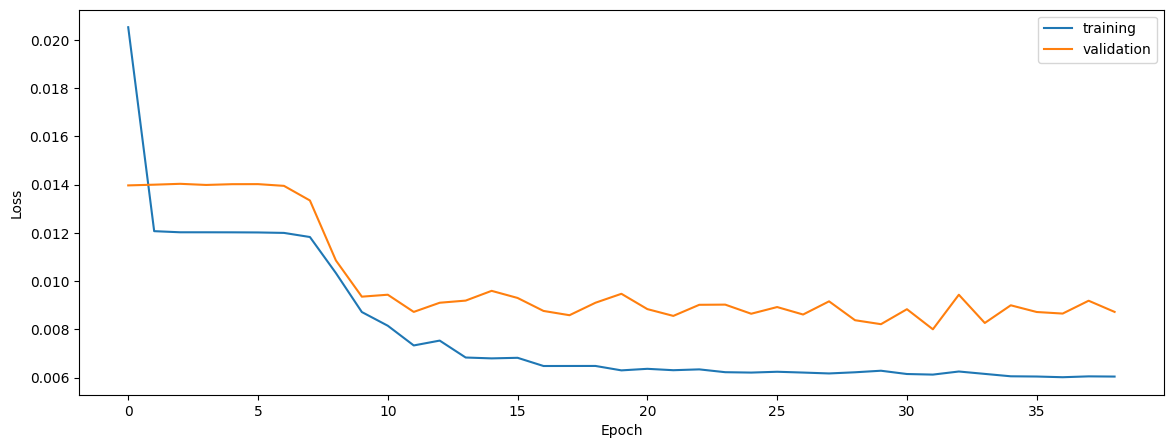

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.7044349137551462
0.6603318252848829
0.6605235624852654


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6934980357298303
0.6742712616135903
0.657937856448379


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6955357202873373
0.675590375532513
0.6701393076317392


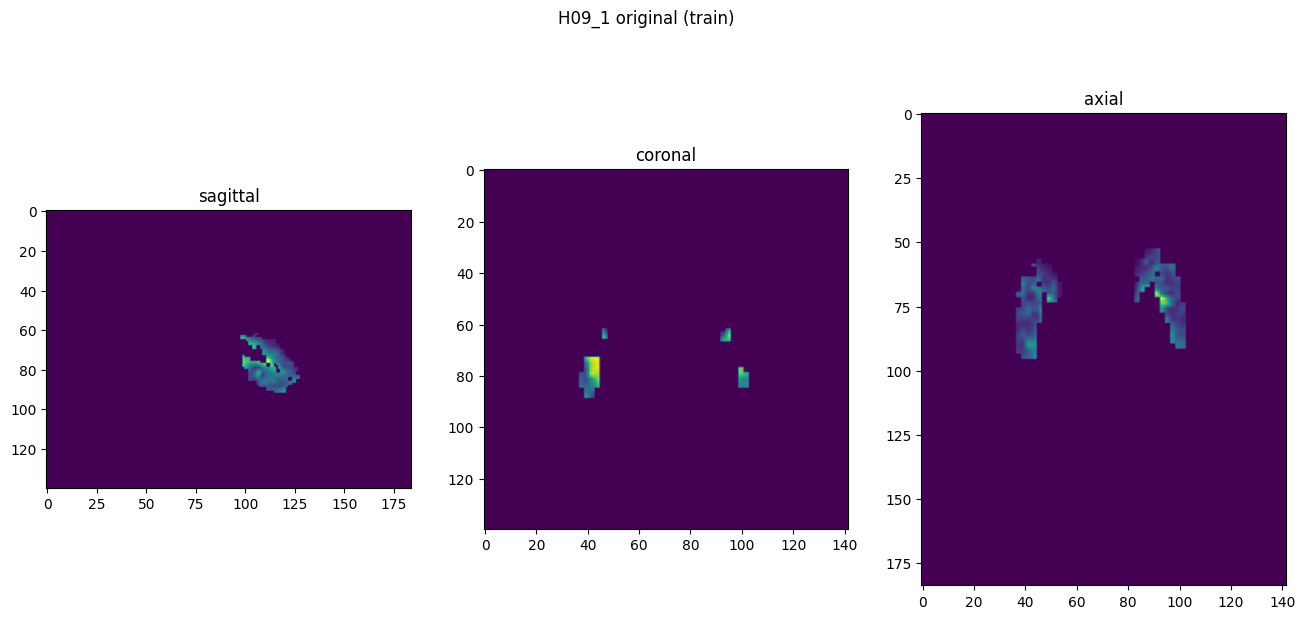

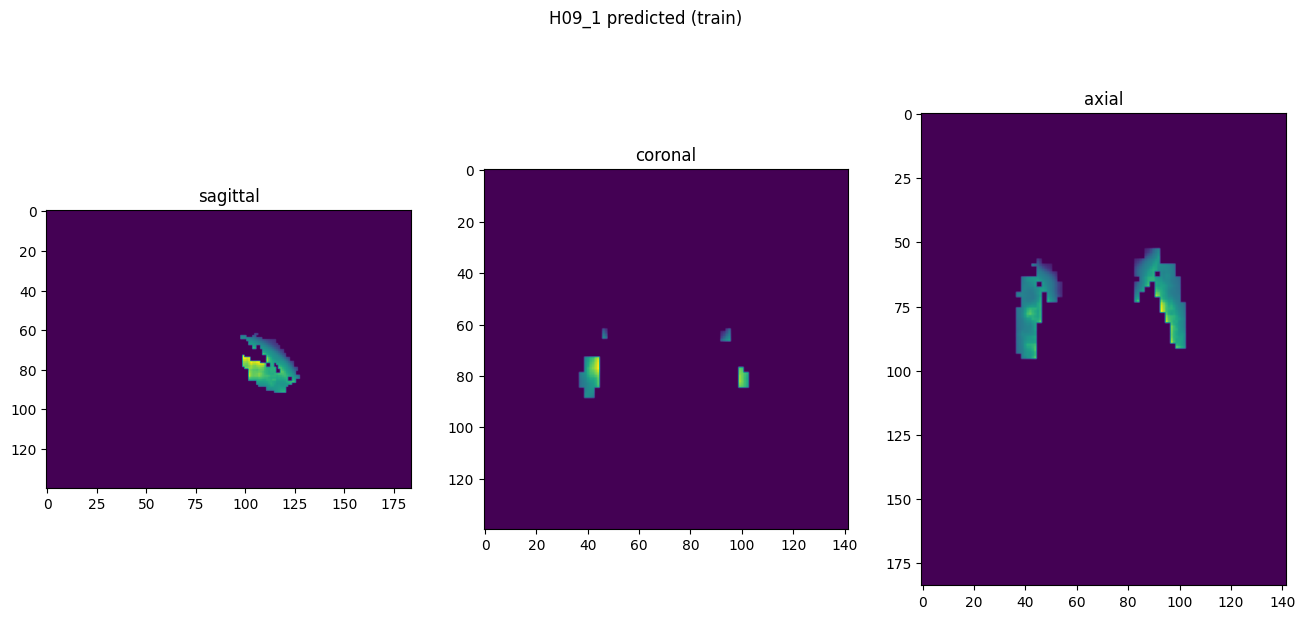

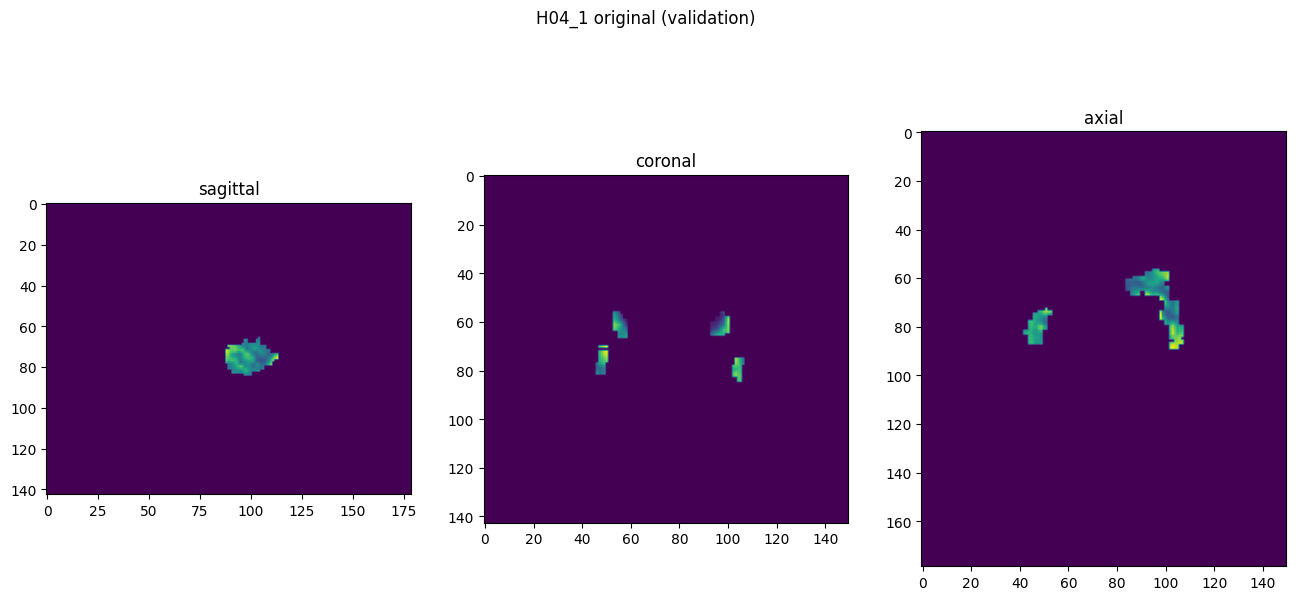

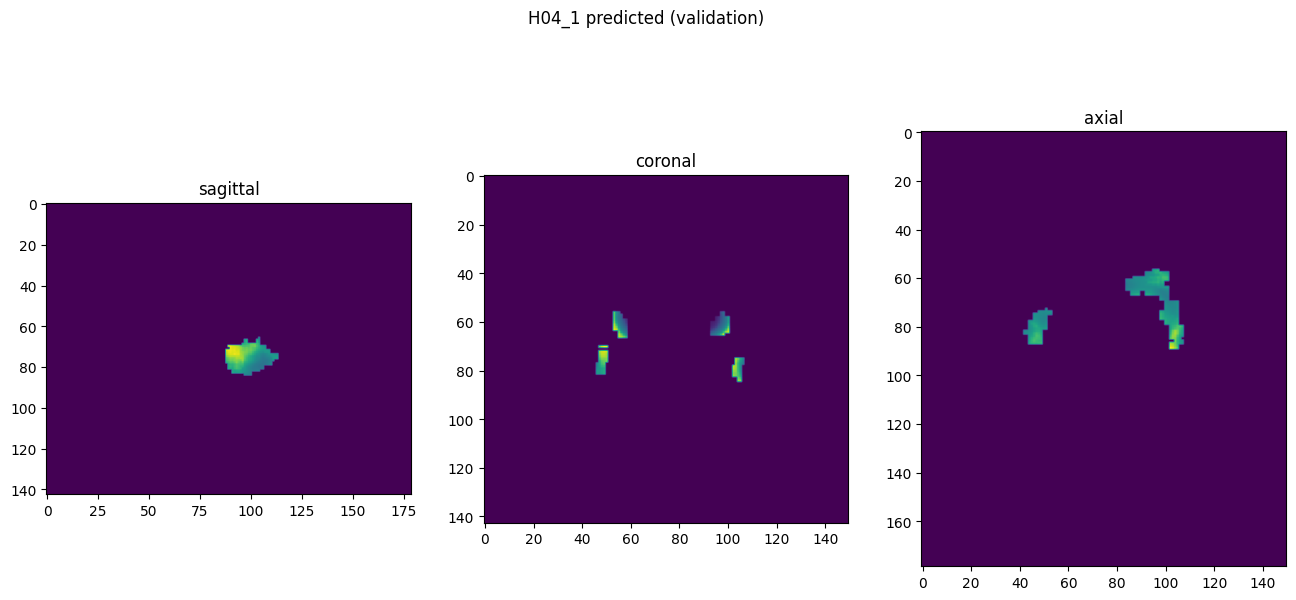

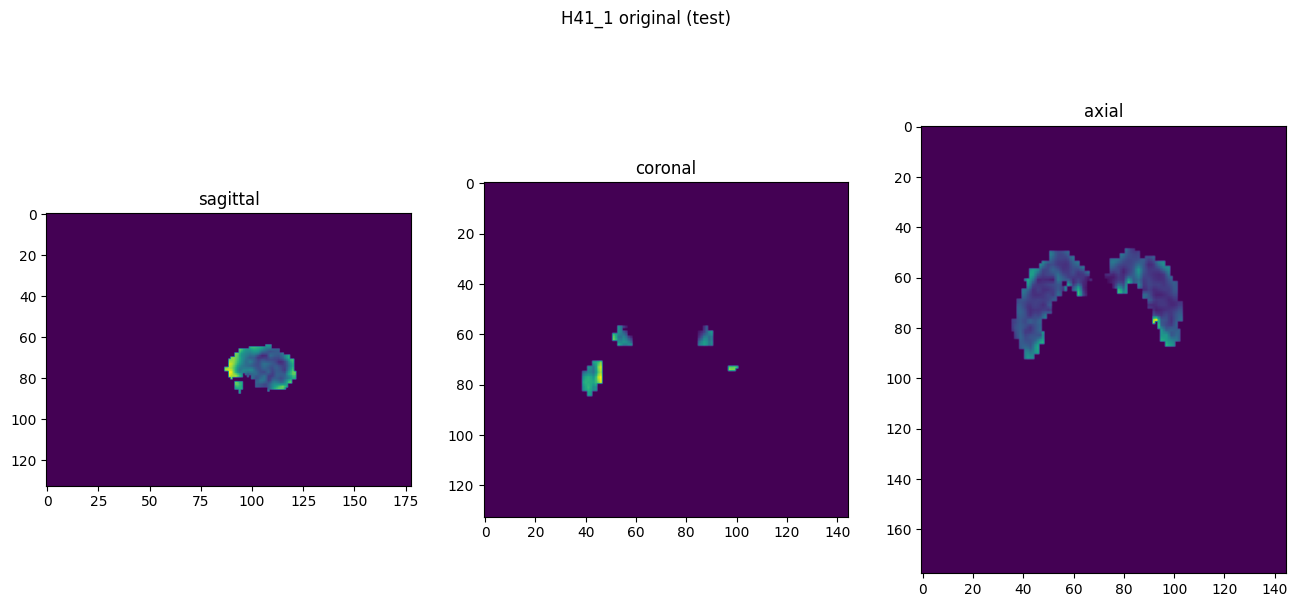

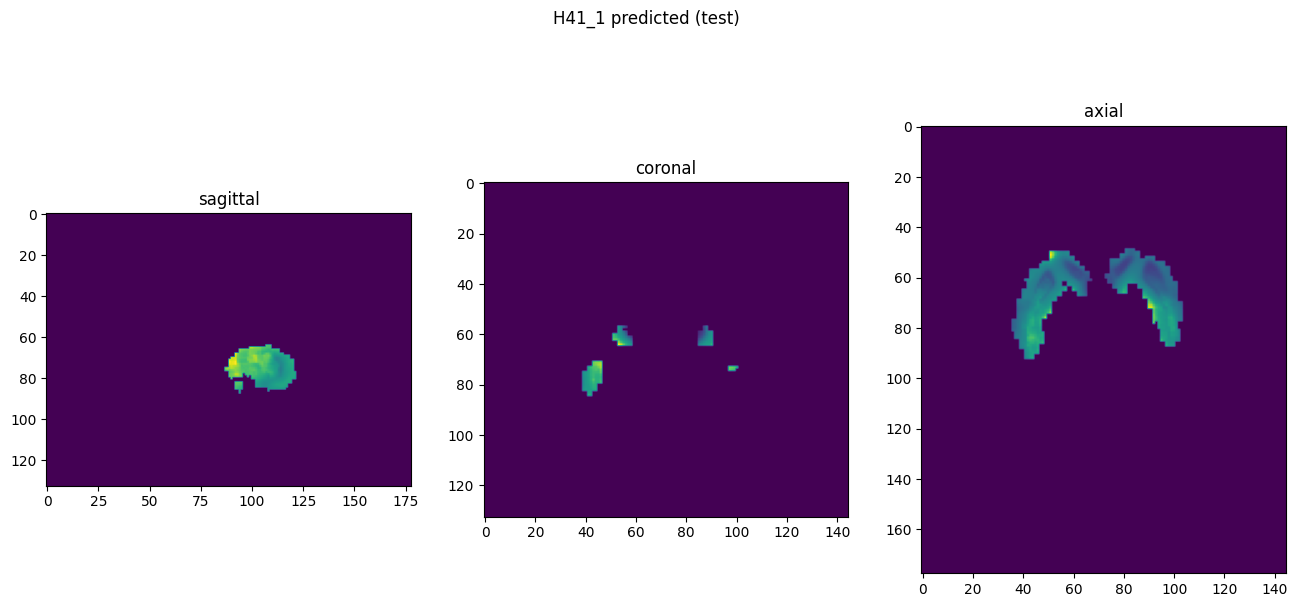

In [10]:
showResults(model, gen, threshold=None, background=False)